# Introduction

The aim of this project is to simulate a time series of successive soccer player action labels and acceleration norms associated with each action.

The problem can be seen as a time series forecasting task, with two main features to predict.
* A categorical feature which is the action label
* A numeric feature which are the acceleration norm

Common models for this kind of tasks are **ARIMA**, **SARIMA**, **LSTM**, **GRU**, **CNN** and, as we will see later, **Transformers**.

The first subtlety of the task is that for one single action label, several norms are associated.
This leads in this project to a forecasting with two models. One will be trained to predict the next action and the second one will be trained to predict the series of norms associated with the predicted action.

The reason why we do not predict serie of norms and associated action at each time is double. First, we avoid generating punctual changing action label over a series of norms supposed to belong to the same action labels.
Then, by predicting high level serie of action label regarding the previous ones, we expect the model to develop a strategic vision of the match progress.

For simplicity and because of lack of time, action will be predicted only according to previous action, without taking in account associated norms.
For Further work, we could imagine an embedding for each norm sequence associated with an action. That could provide relevant features.
For action prediction, we will combine a 1-D **CNN** followed by an **LSTM** model.
By using CNN first, we want to capture game and strategy patterns over a match. Then we use LSTM to handle the numerous output channels and learn temporal dependency.

For norms prediction, we use the **Informer** model from Huggingface transformer package. This model, developed from [Zhou, Haoyi, et al., 2021](https://arxiv.org/abs/2012.07436), is used for multivariate time series forecasting. Compared to vanilla transformer, it reduces time and space complexity.
The interest of this model is that transformers and attention mechanism were shown relevant for time series forecasting.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install -q transformers datasets evaluate accelerate gluonts ujson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import datetime, os
import gc
from pathlib import Path
from warnings import simplefilter

import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

import scipy.stats as ss
import json

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Write your own path to the data json

In [ ]:
match_1_df = pd.read_json("/content/drive/MyDrive/footbar/match_1.json",
   convert_dates=True)

In [ ]:
match_1_df

,label,norm
0,walk,"[23.177037336396975, 23.361525285249378, 21.53..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88..."
...,...,...
569,walk,"[21.245737438782683, 21.938836193196945, 21.24..."
570,walk,"[20.272347748199333, 21.820302584302983, 21.21..."
571,run,"[90.21306005395827, 72.12712844635696, 63.5643..."
572,tackle,"[44.79510251441832, 27.26406867633046, 88.6164..."


In [ ]:
match_2_df = pd.read_json("/content/drive/MyDrive/footbar/match_2.json",
   convert_dates=True)

In [ ]:
match_2_df

,label,norm
0,no action,"[104.42423889328715, 87.63989343949717, 128.52..."
1,run,"[108.03112639951678, 92.57566083451651, 81.303..."
2,pass,"[17.837163554142162, 39.435455203974186, 51.64..."
3,rest,"[21.91843920469922, 18.11914155706377, 21.7137..."
4,walk,"[20.86063916182152, 17.8097748446304, 14.35537..."
...,...,...
608,walk,"[23.337305769963503, 20.210987911153104, 25.06..."
609,walk,"[22.470322813933603, 22.552427730975246, 23.84..."
610,walk,"[43.833612705797144, 46.18045998580312, 37.492..."
611,walk,"[30.927599255773355, 31.26358258808756, 28.286..."


# Data preprocessing

In [ ]:
match_df = pd.concat([match_1_df.copy(), match_2_df.copy()],axis=0).reset_index(drop=True)

## Manage "no action" label

In [ ]:
occur = match_df.groupby(['label']).size()

In [ ]:
match_df.loc[match_df['label'] == 'no action']

,label,norm
574,no action,"[104.42423889328715, 87.63989343949717, 128.52..."
1098,no action,"[51.2820728424938, 45.38173583425492, 34.00457..."


In [ ]:
occur

label
cross          4
dribble       78
no action      2
pass          32
rest          35
run          552
shot          18
tackle        31
walk         435
dtype: int64

Because **no action** label is very rare, **walk** label is very common and **no action** norm values are coherent with **walk** norm values, we choose to change **no action** label to **walk** label.

In [ ]:
match_df.replace('no action', 'walk', inplace=True)

In [ ]:
match_df.loc[match_df['label'] == 'no action']

,label,norm


## One hot action encoder

Convert label feature into one-hot encoder vector.

A norm list is the norm contained in an entire action. So we can associate to each value the percentage of the action progression it represents, according to its index.
The progression list will be the second numeric features, besides the norm, that will be predicted by Informer model. When predicted progression will reached a high enough value, defined by a threshold, it will enable us to define the limit of the norm list associated with an action.

In [ ]:
def progress_array(action_length):
  return np.ndarray.tolist(np.linspace(0, 1, num=action_length))

In [ ]:
progress_column = match_df["norm"].apply(len).apply(progress_array)

In [ ]:
match_df.insert(len(match_df.columns), 'progress', progress_column.values)

In [ ]:
match_df

,label,norm,progress
0,walk,"[23.177037336396975, 23.361525285249378, 21.53...","[0.0, 0.014084507042253521, 0.0281690140845070..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...","[0.0, 0.018867924528301886, 0.0377358490566037..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...","[0.0, 0.014925373134328358, 0.0298507462686567..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...","[0.0, 0.013513513513513514, 0.0270270270270270..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...","[0.0, 0.005555555555555556, 0.0111111111111111..."
...,...,...,...
1182,walk,"[23.337305769963503, 20.210987911153104, 25.06...","[0.0, 0.0196078431372549, 0.0392156862745098, ..."
1183,walk,"[22.470322813933603, 22.552427730975246, 23.84...","[0.0, 0.015873015873015872, 0.0317460317460317..."
1184,walk,"[43.833612705797144, 46.18045998580312, 37.492...","[0.0, 0.01694915254237288, 0.03389830508474576..."
1185,walk,"[30.927599255773355, 31.26358258808756, 28.286...","[0.0, 0.015384615384615385, 0.0307692307692307..."


In [ ]:
match_df = pd.get_dummies(match_df, columns=['label', ])

In [ ]:
match_df

,norm,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,"[23.177037336396975, 23.361525285249378, 21.53...","[0.0, 0.014084507042253521, 0.0281690140845070...",0,0,0,0,0,0,0,1
1,"[20.998214383911275, 19.182798059840767, 18.27...","[0.0, 0.018867924528301886, 0.0377358490566037...",0,0,0,0,0,0,0,1
2,"[21.95259682019565, 20.62720484424047, 22.5554...","[0.0, 0.014925373134328358, 0.0298507462686567...",0,0,0,0,0,0,0,1
3,"[19.39209748358647, 19.30460665293087, 18.9787...","[0.0, 0.013513513513513514, 0.0270270270270270...",0,0,0,0,0,0,0,1
4,"[22.069263037713093, 19.672270483203395, 19.88...","[0.0, 0.005555555555555556, 0.0111111111111111...",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1182,"[23.337305769963503, 20.210987911153104, 25.06...","[0.0, 0.0196078431372549, 0.0392156862745098, ...",0,0,0,0,0,0,0,1
1183,"[22.470322813933603, 22.552427730975246, 23.84...","[0.0, 0.015873015873015872, 0.0317460317460317...",0,0,0,0,0,0,0,1
1184,"[43.833612705797144, 46.18045998580312, 37.492...","[0.0, 0.01694915254237288, 0.03389830508474576...",0,0,0,0,0,0,0,1
1185,"[30.927599255773355, 31.26358258808756, 28.286...","[0.0, 0.015384615384615385, 0.0307692307692307...",0,0,0,0,0,0,0,1


## Action forecasting

### Action history

Select only labels columns.

In [ ]:
actions_col = []
for col in match_df.columns:
  if "label_" in col:
    actions_col.append(col)

In [ ]:
actions_col

['label_cross',
 'label_dribble',
 'label_pass',
 'label_rest',
 'label_run',
 'label_shot',
 'label_tackle',
 'label_walk']

In [ ]:
actions_df = match_df[actions_col]

In [ ]:
actions_df

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1182,0,0,0,0,0,0,0,1
1183,0,0,0,0,0,0,0,1
1184,0,0,0,0,0,0,0,1
1185,0,0,0,0,0,0,0,1


### Lag + multi step

For each row, concatenate previous action one-hot encoder and next ones according to sset parameters.

In [ ]:
lag = 3

In [ ]:
forward = 1

In [ ]:
actions_lag_df = pd.concat([actions_df.shift(i).add_suffix(" - "+str(i)) for i in range(lag,0,-1)]
                             + [actions_df.shift(-i).add_suffix(" + "+str(i)) for i in range(0,forward,1)], axis=1)

In [ ]:
actions_lag_df.columns

Index(['label_cross - 3', 'label_dribble - 3', 'label_pass - 3',
       'label_rest - 3', 'label_run - 3', 'label_shot - 3', 'label_tackle - 3',
       'label_walk - 3', 'label_cross - 2', 'label_dribble - 2',
       'label_pass - 2', 'label_rest - 2', 'label_run - 2', 'label_shot - 2',
       'label_tackle - 2', 'label_walk - 2', 'label_cross - 1',
       'label_dribble - 1', 'label_pass - 1', 'label_rest - 1',
       'label_run - 1', 'label_shot - 1', 'label_tackle - 1', 'label_walk - 1',
       'label_cross + 0', 'label_dribble + 0', 'label_pass + 0',
       'label_rest + 0', 'label_run + 0', 'label_shot + 0', 'label_tackle + 0',
       'label_walk + 0'],
      dtype='object')

In [ ]:
actions_lag_df

,label_cross - 3,label_dribble - 3,label_pass - 3,label_rest - 3,label_run - 3,label_shot - 3,label_tackle - 3,label_walk - 3,label_cross - 2,label_dribble - 2,...,label_tackle - 1,label_walk - 1,label_cross + 0,label_dribble + 0,label_pass + 0,label_rest + 0,label_run + 0,label_shot + 0,label_tackle + 0,label_walk + 0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0,0,0,0,0,0,0,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,1.0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,0,0,0,0,1
1183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,0,0,0,0,1
1184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,0,0,0,0,1
1185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,0,0,0,0,1


In [ ]:
action_column_nb = len(actions_lag_df.columns)

In [ ]:
action_column_nb

32

## Norm forecasting

### One row per norm

Convert dataframe with one row per action to a dataframe with one row per norm value with its associated action at each time.

In [ ]:
continous_df = pd.DataFrame(columns=match_df.columns)

In [ ]:
for row_ind in match_df.index:
  duration = len(match_df["norm"][row_ind])
  for step in range(duration):
    new_row = dict()
    for column_name in match_df.columns:
      if "label_" in column_name:
        new_row[column_name] = match_df[column_name][row_ind]
      else:
        new_row[column_name] = match_df[column_name][row_ind][step]
    continous_df.loc[len(continous_df)] = new_row

In [ ]:
continous_df

,norm,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,23.177037,0.000000,0,0,0,0,0,0,0,1
1,23.361525,0.014085,0,0,0,0,0,0,0,1
2,21.535253,0.028169,0,0,0,0,0,0,0,1
3,23.400315,0.042254,0,0,0,0,0,0,0,1
4,23.007525,0.056338,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
55848,22.656781,0.943662,0,0,0,0,0,0,0,1
55849,23.648124,0.957746,0,0,0,0,0,0,0,1
55850,20.462536,0.971831,0,0,0,0,0,0,0,1
55851,20.206790,0.985915,0,0,0,0,0,0,0,1


In [ ]:
continous_df.to_csv('/content/drive/MyDrive/footbar/continous_df.csv', index=False)

### Load from continous_df.csv

The previous step take times. If resulted file has been saved, we can load it in this part.

In [ ]:
continous_df = pd.read_csv("/content/drive/MyDrive/footbar/continous_df.csv")

In [ ]:
continous_df

,norm,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,23.177037,0.000000,0,0,0,0,0,0,0,1
1,23.361525,0.014085,0,0,0,0,0,0,0,1
2,21.535253,0.028169,0,0,0,0,0,0,0,1
3,23.400315,0.042254,0,0,0,0,0,0,0,1
4,23.007525,0.056338,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
55848,22.656781,0.943662,0,0,0,0,0,0,0,1
55849,23.648124,0.957746,0,0,0,0,0,0,0,1
55850,20.462536,0.971831,0,0,0,0,0,0,0,1
55851,20.206790,0.985915,0,0,0,0,0,0,0,1


In [ ]:
continous_df.columns

Index(['norm', 'progress', 'label_cross', 'label_dribble', 'label_pass',
       'label_rest', 'label_run', 'label_shot', 'label_tackle', 'label_walk'],
      dtype='object')

### Place predicted features at the end of the dataframe.

In [ ]:
nb_features = len(continous_df.columns)

In [ ]:
new_cols = ['label_cross', 'label_dribble', 'label_pass', 'label_rest', 'label_run', 'label_shot', 'label_tackle', 'label_walk','norm', 'progress']
continous_df=continous_df[new_cols]

In [ ]:
continous_df

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk,norm,progress
0,0,0,0,0,0,0,0,1,23.177037,0.000000
1,0,0,0,0,0,0,0,1,23.361525,0.014085
2,0,0,0,0,0,0,0,1,21.535253,0.028169
3,0,0,0,0,0,0,0,1,23.400315,0.042254
4,0,0,0,0,0,0,0,1,23.007525,0.056338
...,...,...,...,...,...,...,...,...,...,...
55848,0,0,0,0,0,0,0,1,22.656781,0.943662
55849,0,0,0,0,0,0,0,1,23.648124,0.957746
55850,0,0,0,0,0,0,0,1,20.462536,0.971831
55851,0,0,0,0,0,0,0,1,20.206790,0.985915


### Scale data

Scale numeric data between -1 and 1 to normalized them.

In [ ]:
train_prop = 0.8

In [ ]:
raw_values = continous_df[["norm","progress"]].values

# Perform scaling only on the train split to avoid information leakage
train_raw_values = raw_values[:int(0.8 * raw_values.shape[0])]
scaler_train = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler_train.fit_transform(train_raw_values)
scaler_test = MinMaxScaler(feature_range=(-1, 1))
scaled_test = scaler_test.fit_transform(raw_values[int(0.8 * raw_values.shape[0]):])

scaled = np.concatenate((scaled_train,scaled_test),axis=0)

In [ ]:
continous_df_scaled = continous_df.copy()
continous_df_scaled["norm"] = scaled[:,0]
continous_df_scaled["progress"] = scaled[:,1]

In [ ]:
continous_df_scaled

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk,norm,progress
0,0,0,0,0,0,0,0,1,-0.944424,-1.000000
1,0,0,0,0,0,0,0,1,-0.943947,-0.971831
2,0,0,0,0,0,0,0,1,-0.948668,-0.943662
3,0,0,0,0,0,0,0,1,-0.943847,-0.915493
4,0,0,0,0,0,0,0,1,-0.944862,-0.887324
...,...,...,...,...,...,...,...,...,...,...
55848,0,0,0,0,0,0,0,1,-0.942453,0.887324
55849,0,0,0,0,0,0,0,1,-0.939692,0.915493
55850,0,0,0,0,0,0,0,1,-0.948566,0.943662
55851,0,0,0,0,0,0,0,1,-0.949279,0.971831


# Data Analysis

## Action proportions

Here, we plot a bar chart representing the total occurences for each labels insides the matches data. It gives a representation of how much an action appear and how high would be the bias induced in action forecasting.

In [ ]:
occur = match_df.groupby(['label']).size()

In [ ]:
occur

label
cross        4
dribble     78
pass        32
rest        35
run        552
shot        18
tackle      31
walk       437
dtype: int64

<Axes: xlabel='label'>

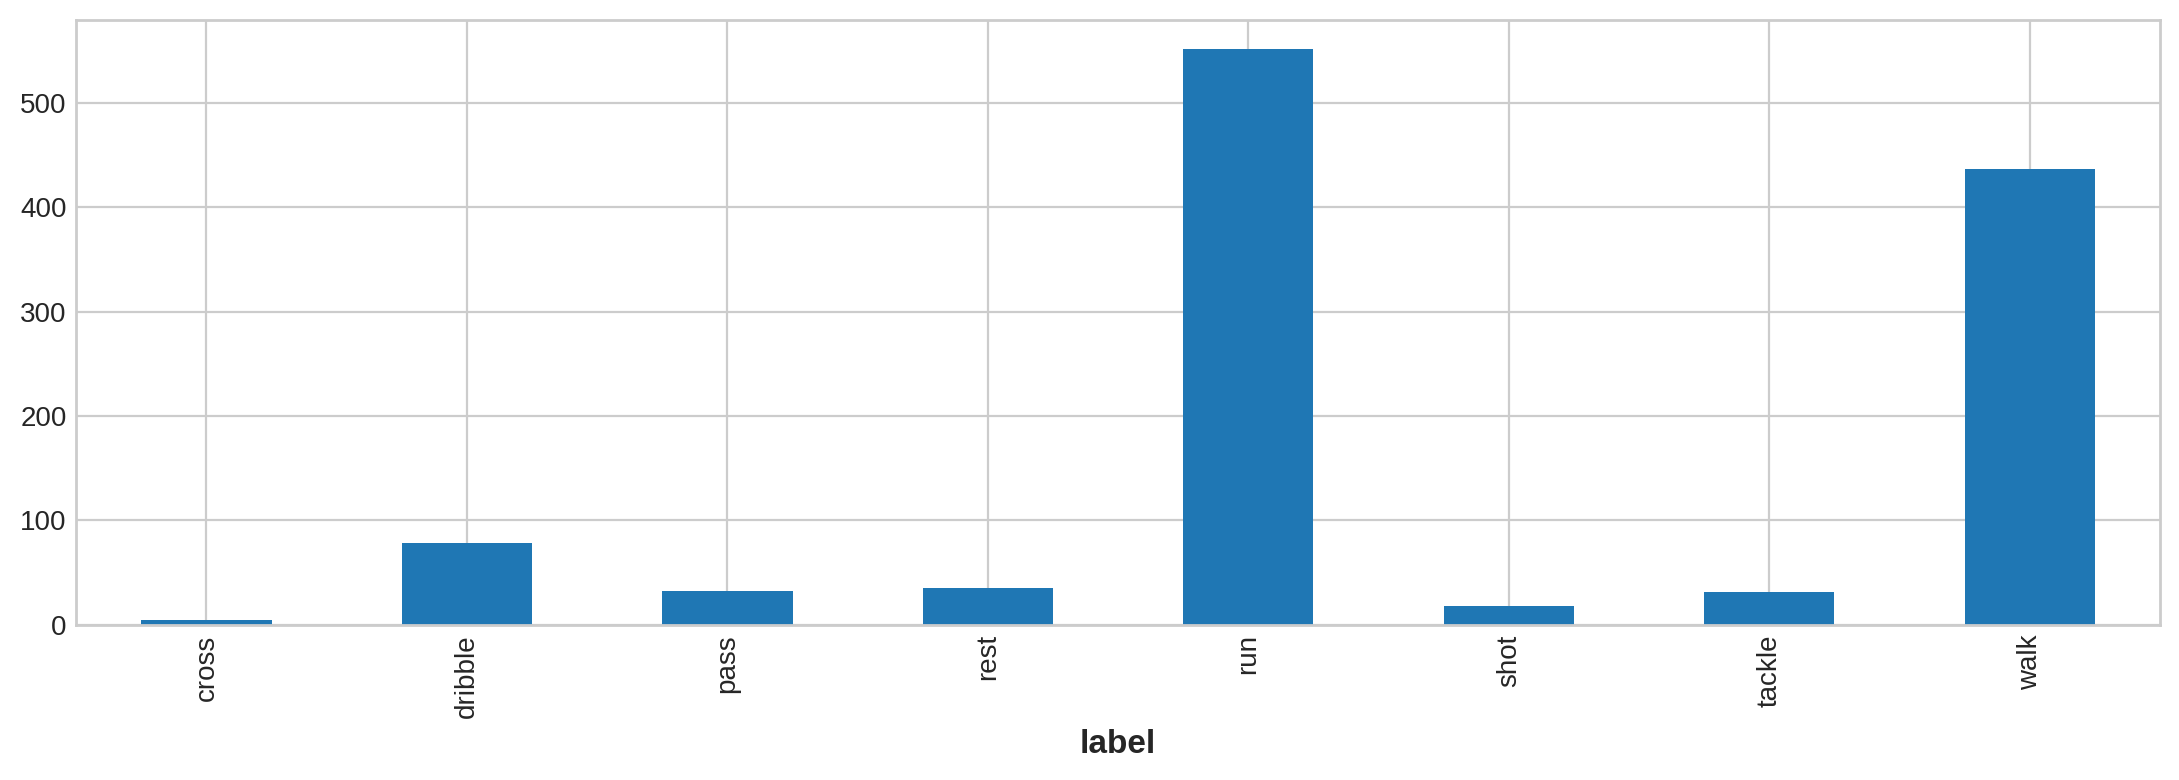

In [ ]:
occur.plot.bar()

We can see a large majority of **run** and **walk** action during matches, which is not surprising.

The problem is that, if we pass these data to an action prediction model, the model should be strongly biased and will always output either run or walked. In the next part of data processing, we will try to harmonize the amout of the label occurence in training data, in order to reduce the bias.

Nevertheless, a slight majority of **run** and **walk** label is interesting, as we though want to find in the final simulation similar proportion of label occurence.

## Action norm according to time

Here, we want to plot norms along time with respect to different action. As an example, we take the action **dribble** to see if we can find norm pattern along time.

In [ ]:
match_df_dribble = match_df[match_df["label_dribble"] == 1].reset_index()

In [ ]:
match_df_dribble

,index,norm,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,59,"[28.985802058905858, 26.17263539170306, 21.234...","[0.0, 0.02040816326530612, 0.04081632653061224...",0,1,0,0,0,0,0,0
1,61,"[36.7679023106896, 52.193783512146645, 39.8861...","[0.0, 0.015151515151515152, 0.0303030303030303...",0,1,0,0,0,0,0,0
2,99,"[165.60022002731776, 95.0403340245988, 123.192...","[0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28,...",0,1,0,0,0,0,0,0
3,143,"[38.385376683655714, 80.09656145561165, 327.35...","[0.0, 0.030303030303030304, 0.0606060606060606...",0,1,0,0,0,0,0,0
4,144,"[11.417629851331728, 30.644828317562485, 36.29...","[0.0, 0.03225806451612903, 0.06451612903225806...",0,1,0,0,0,0,0,0
5,145,"[43.66868663743135, 22.141037391909983, 50.475...","[0.0, 0.030303030303030304, 0.0606060606060606...",0,1,0,0,0,0,0,0
6,149,"[64.32656089260917, 59.47734639689241, 54.1981...","[0.0, 0.023809523809523808, 0.0476190476190476...",0,1,0,0,0,0,0,0
7,161,"[72.25627314317839, 54.2957710759941, 66.73306...","[0.0, 0.02564102564102564, 0.05128205128205128...",0,1,0,0,0,0,0,0
8,162,"[115.8644956448211, 101.7489479804738, 29.0776...","[0.0, 0.03225806451612903, 0.06451612903225806...",0,1,0,0,0,0,0,0
9,163,"[45.30429846452836, 67.45064187481834, 126.692...","[0.0, 0.030303030303030304, 0.0606060606060606...",0,1,0,0,0,0,0,0


First, a single action norms plot along time to have a simple visualization.

[36.7679023106896, 52.193783512146645, 39.88617562275928, 46.97174490615837, 32.73645002504101, 32.05252936269998, 30.82817778552077, 28.88877997026124, 27.22374053565026, 36.7435432747199, 48.7701778738009, 54.44250067810035, 48.811696141810756, 40.29446056303425, 33.07664597444781, 23.171821583336737, 25.1493671765296, 42.989866843212425, 48.90306952802432, 40.2132903217914, 32.338960459343, 53.77288113498869, 47.6551769829168, 33.724704124188165, 25.71957029795113, 23.28036984123904, 28.83428622169777, 35.81944977521244, 25.75445084805468, 15.638361564554456, 10.433036451621684, 27.927507047370412, 24.47969811686861, 14.204640673571088, 14.2662079899307, 35.46541403460756, 131.43153898560226, 24.25799904092894, 68.16682179186162, 31.433589322950134, 53.680631370633016, 40.85777076675458, 40.62730043172789, 26.622091917352087, 28.293500502214155, 31.592309111221336, 28.32822621081186, 37.00876841459681, 54.617409324838476, 62.0794203315731, 53.22040595694533, 42.480200949853725, 27.0

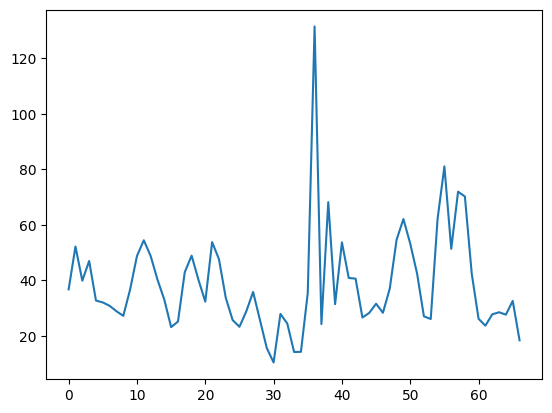

In [ ]:
print(match_df_dribble.loc[1]["norm"])
norms = match_df_dribble.loc[1]["norm"]
plt.plot([i for i in range(len(norms))], norms)
plt.show()

Then we plot all the **dribble** actions norms list on the same plot to check if we can find recurrent pattern.

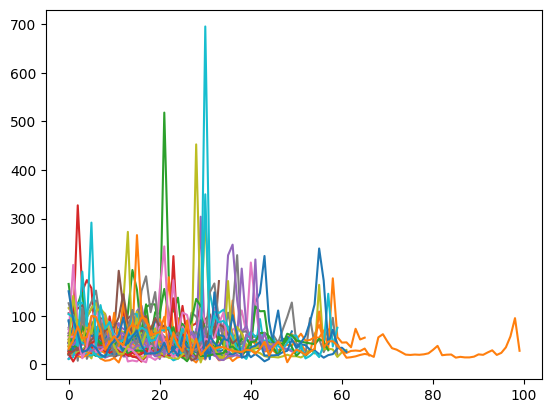

In [ ]:
for ind in match_df_dribble.index:
  norms = match_df_dribble.loc[ind]["norm"]
  plt.plot([i for i in range(len(norms))], norms)

plt.show()

As we can see, because of the various length of an action, the plot is quite confusing because one long action make the rest of the visualization too "tight".

To prevent that, we can think that too similar labelled action have different length, but have the same execution diagram. That is why in the next part we plot norms along the percentage of progression of the action, from O to 1.

## Action norm according to progression

Here, we choose to plot, for each action label, the evolution of the norm according to the action progression. To do that, for one action, according to its length, we associate to each norm value the percentage of the action progression, from 0. to 1., to which this value belong.

It enables us to plot several actions norms list on the same plot with a unique x-axis dimension, which ease the detection of norm evolution pattern for a type of action.

In [ ]:
actions_labels = []
for label in match_df.columns:
  if "label_" in label:
    actions_labels.append(label)

In [ ]:
actions_labels

['label_cross',
 'label_dribble',
 'label_pass',
 'label_rest',
 'label_run',
 'label_shot',
 'label_tackle',
 'label_walk']

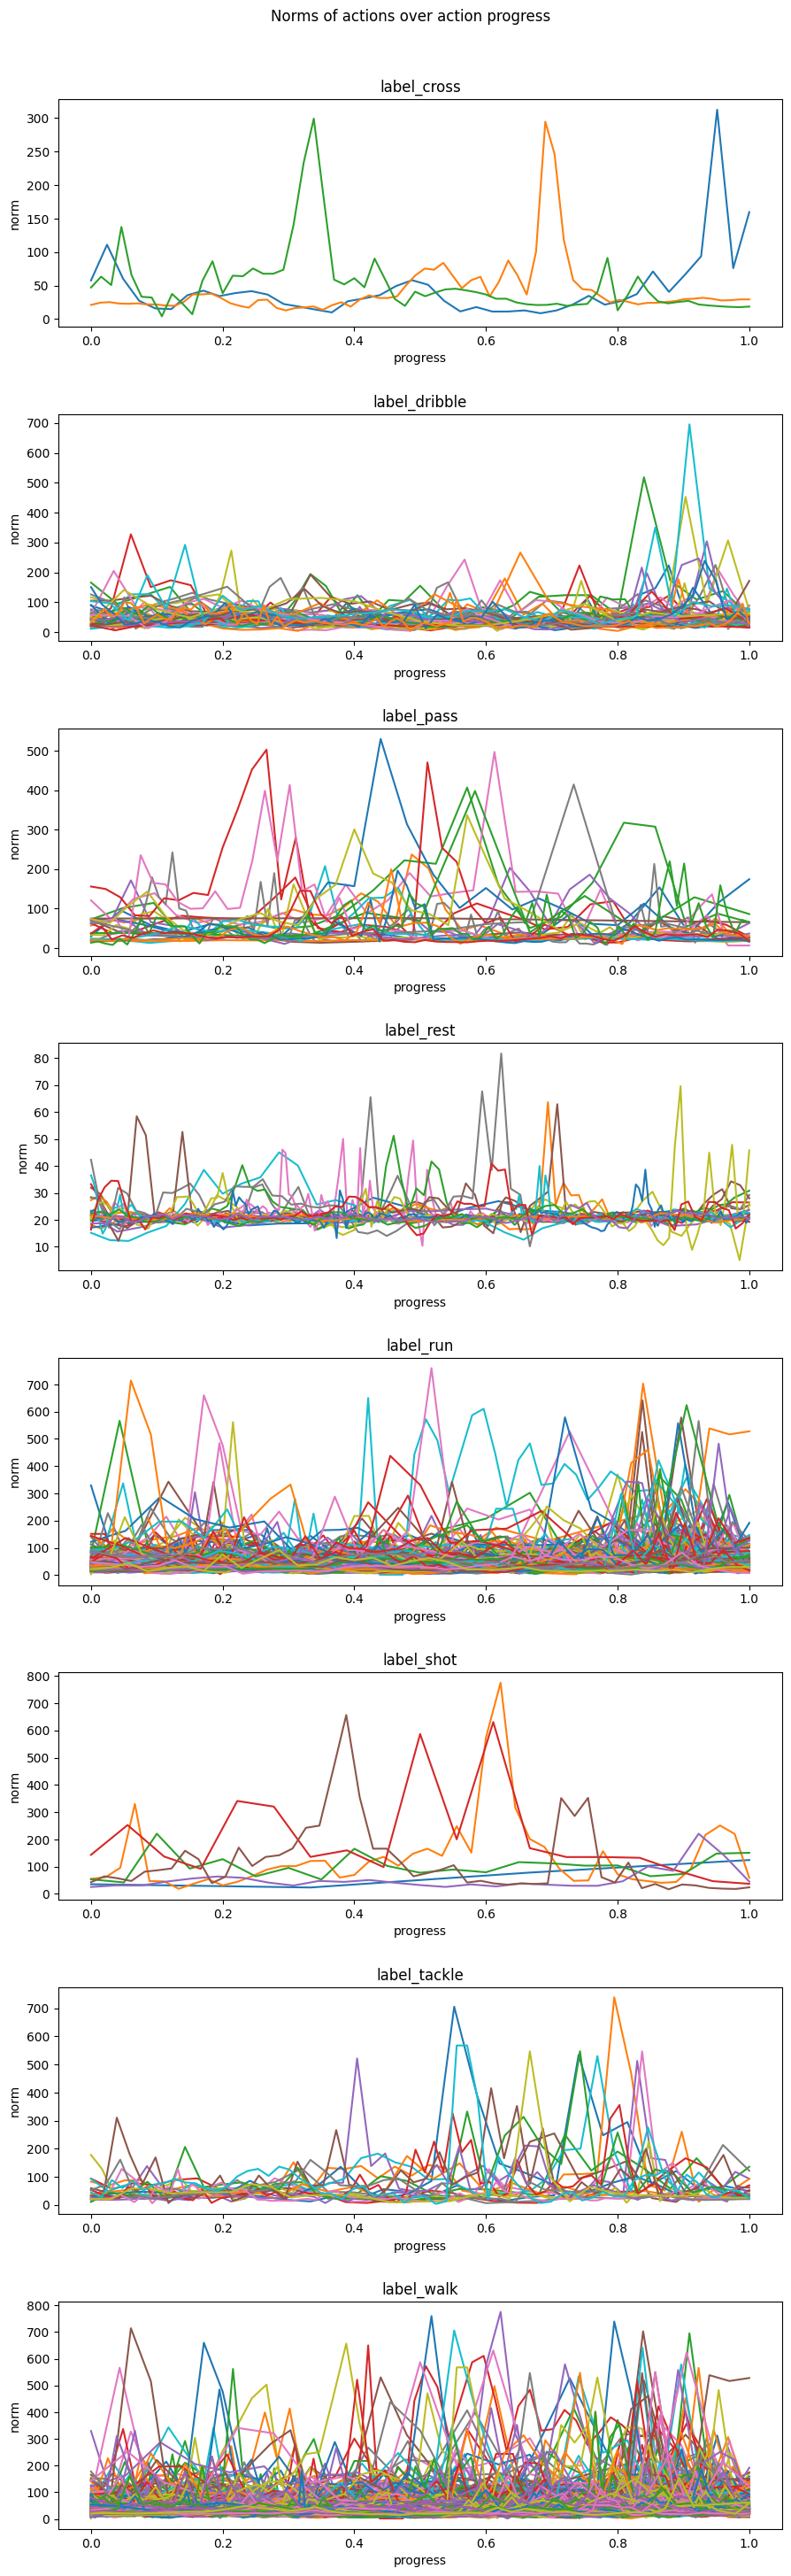

In [ ]:
fig, axs = plt.subplots(len(actions_labels))
fig.suptitle('Norms of actions over action progress')
fig.set_figheight(30)
fig.set_figwidth(10)
fig.tight_layout(pad=5.0)
for label_ind, label in enumerate(actions_labels):
  match_df_action = match_df[match_df[label] == 1].reset_index()
  for ind in match_df_action.index:
    norms = match_df_action.loc[ind]["norm"]
    progress = match_df_action.loc[ind]["progress"]
    plt.plot(progress, norms)
    axs[label_ind].plot(progress, norms)

  axs[label_ind].set_title(label)

for ax in axs.flat:
    ax.set(xlabel='progress', ylabel='norm')

plt.show()

We can see that actions have different typical profile. For example, a pass usually has big acceleration norms during its gait, certainly due to the shoot of the ball.

In the contrary, rest action is stable around relatively low norm values all along the gait, which is certainly.

The goal of the norm forecasting model will be to reproduce the norm profile according to an action label one-hot encoder passed as input.

## Norm lag plot

Here, we compute the correlation of a norm value compared to previous norms. As it is a time series problem, we want to use previous norms as input of the model to simulate future norm values. We want to check how many lags are useful thanks to a lag plot and partial autocorrelation plot over **6 lags**.

In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


<ipython-input-25-e3dd87950e99>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


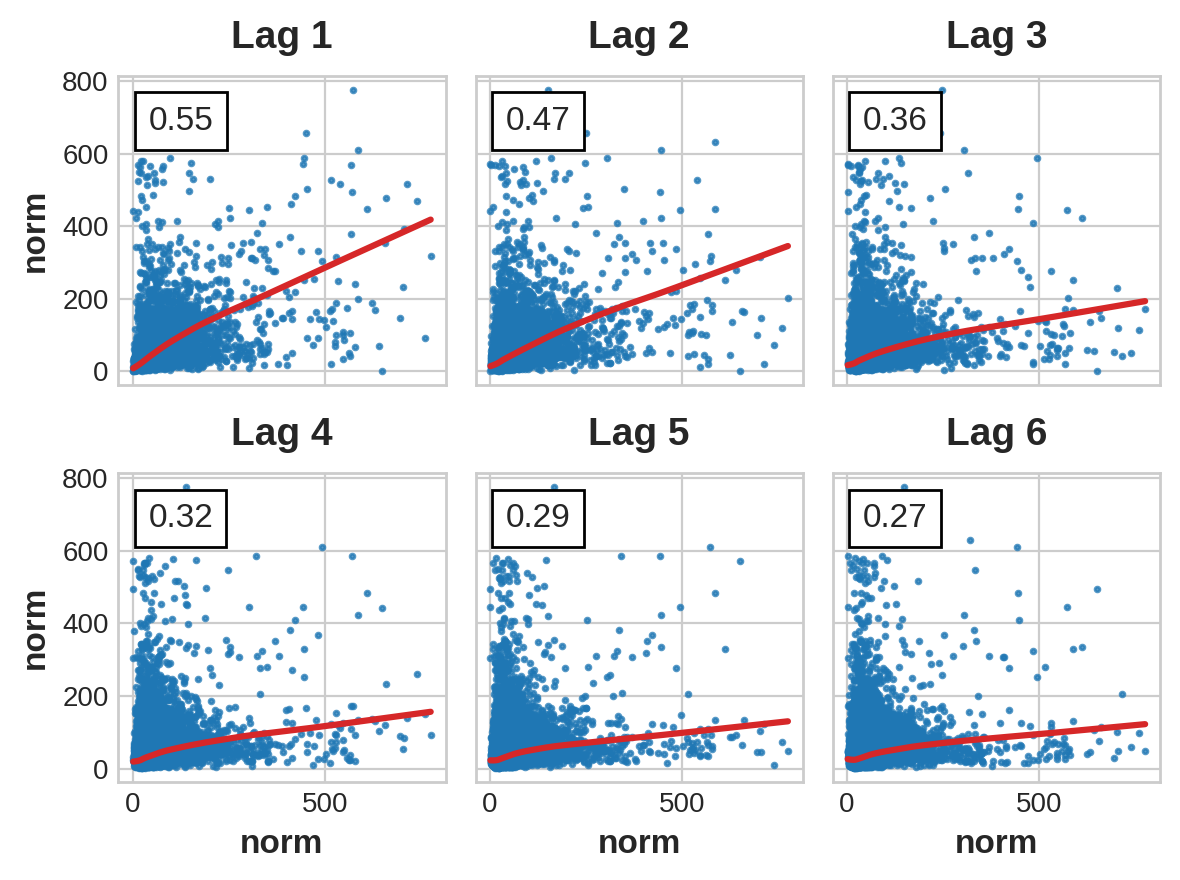

In [ ]:
_ = plot_lags(continous_df.norm, lags=6, nrows=2)

We can see significant correlation between a norm value and previous norms until 6 steps before.

Next we check the contribution of each new lags added.

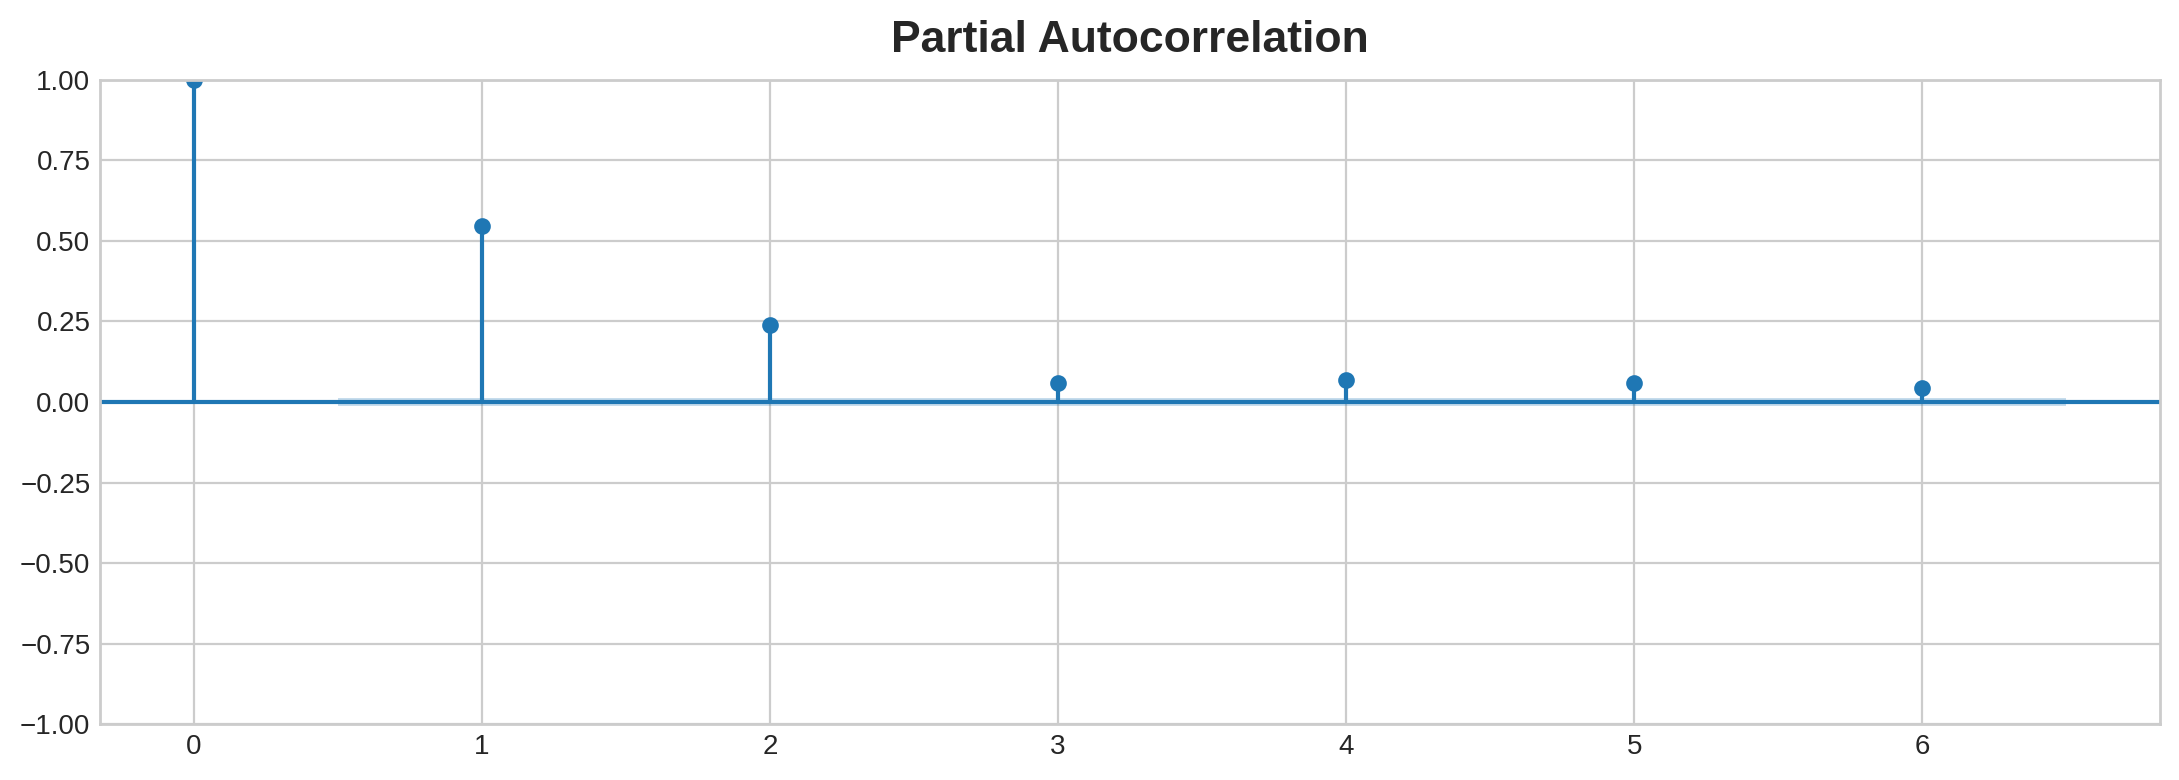

In [ ]:
_ = plot_pacf(continous_df.norm, lags=6)

We can see that lags **1 and 2** each brings new relevant information when taken simultaneously into account. More lags are not so relevant.

For simplicity and security purpose, we will take also **lag 3**.

## Norm over a match

Here we compute the Simple Moving Average over all the norms of a match to check the presence of a trend.
For example, due to increasing tiredness of a player during a match, we can think that his global acceleration could be lower at the end of the match than at its begining.

The size of the rolling window is **500**.

In [ ]:
continous_df

,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk,norm
0,0.000000,0,0,0,0,0,0,0,1,23.177037
1,0.014085,0,0,0,0,0,0,0,1,23.361525
2,0.028169,0,0,0,0,0,0,0,1,21.535253
3,0.042254,0,0,0,0,0,0,0,1,23.400315
4,0.056338,0,0,0,0,0,0,0,1,23.007525
...,...,...,...,...,...,...,...,...,...,...
27842,0.885714,0,0,0,0,1,0,0,0,19.883602
27843,0.914286,0,0,0,0,1,0,0,0,11.203680
27844,0.942857,0,0,0,0,1,0,0,0,24.701711
27845,0.971429,0,0,0,0,1,0,0,0,30.045599


In [ ]:
norms_df = continous_df["norm"].to_frame()
norms_df["SMA"] = norms_df["norm"].rolling(500).mean()
norms_df.fillna(0)

,norm,SMA
0,23.177037,0.000000
1,23.361525,0.000000
2,21.535253,0.000000
3,23.400315,0.000000
4,23.007525,0.000000
...,...,...
27842,19.883602,35.456403
27843,11.203680,35.404089
27844,24.701711,35.396377
27845,30.045599,35.406370


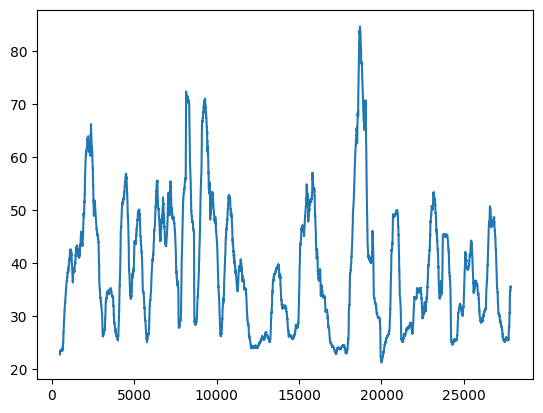

In [ ]:
norms_avg = norms_df["SMA"].values
plt.plot([i for i in range(len(norms_avg))],norms_avg)
#plt.yscale("log")
plt.show()


We can see that the global amplitude of the variation of the norm average is lower at the end of the match than at its begining. But as we cannot see obvious trend, for simplicity reason of the problem modelling, we ignore the presence of any trend.

##  Cramer’s V Categorical correlation

Here we chack the correlation between the categorical label feature compared to previous labels using different lags. The correlation scores are computed using the Cramer’s V correlation as it is defined in [this](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) article.

In [ ]:
label_df = match_1_df['label'].to_frame()

In [ ]:
label_df

,label
0,walk
1,walk
2,walk
3,walk
4,rest
...,...
569,walk
570,walk
571,run
572,tackle


In [ ]:
analysis_lag = 9

In [ ]:
label_lag_df = pd.concat([label_df.shift(i).add_suffix(" - "+str(i)) for i in range(analysis_lag,0,-1)] + [label_df],axis=1)
label_lag_df.fillna(0)

,label - 9,label - 8,label - 7,label - 6,label - 5,label - 4,label - 3,label - 2,label - 1,label
0,0,0,0,0,0,0,0,0,0,walk
1,0,0,0,0,0,0,0,0,walk,walk
2,0,0,0,0,0,0,0,walk,walk,walk
3,0,0,0,0,0,0,walk,walk,walk,walk
4,0,0,0,0,0,walk,walk,walk,walk,rest
...,...,...,...,...,...,...,...,...,...,...
569,walk,walk,walk,walk,walk,walk,walk,walk,walk,walk
570,walk,walk,walk,walk,walk,walk,walk,walk,walk,walk
571,walk,walk,walk,walk,walk,walk,walk,walk,walk,run
572,walk,walk,walk,walk,walk,walk,walk,walk,run,tackle


In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
for col_lag in label_lag_df.columns:
  corr = cramers_v(label_lag_df[col_lag], label_lag_df[label_lag_df.columns[-1]])
  print(f'Correlation between {col_lag} and {label_lag_df.columns[-1]} : {corr}')

Correlation between label - 9 and label : 0.0
Correlation between label - 8 and label : 0.04046387023366828
Correlation between label - 7 and label : 0.06173082902433313
Correlation between label - 6 and label : 0.05917938137192403
Correlation between label - 5 and label : 0.06523443936977119
Correlation between label - 4 and label : 0.0944139405700259
Correlation between label - 3 and label : 0.11700630611340193
Correlation between label - 2 and label : 0.23939849912838576
Correlation between label - 1 and label : 0.3679049386303041
Correlation between label and label : 1.0


We can conclude that correlation score can be interesting until the **3 previous gaits**.

# Norm forecasting

## Informer

### Dataset

In [ ]:
prediction_length = 100

In [ ]:
scaled_numpy = np.transpose(continous_df_scaled.to_numpy())

In [ ]:
scaled_numpy.shape

(10, 27847)

In [ ]:
scaled_numpy = np.float32(scaled_numpy)

In [ ]:

train_idx = int(scaled_numpy.shape[-1] * train_prop)

In [ ]:
train_idx

22277

In [ ]:
multi_variate_train_dataset = [{
    'feat_dynamic_real': scaled_numpy[:-2,:train_idx],
    'target': scaled_numpy[-2:,:train_idx],
    'start': 0,
}]

multi_variate_test_dataset = [{
    'feat_dynamic_real': scaled_numpy[:-2,train_idx:],
    'target': scaled_numpy[-2:,train_idx:],
    'start': 0,
}]

In [ ]:
# Take into account prediction length
multi_variate_test_dataset[0]['target'] = multi_variate_test_dataset[0]['target'][:,prediction_length:]

In [ ]:
lags_sequence =  [1, 2, 3]

### Model

In [ ]:
from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=multi_variate_train_dataset[0]['target'].shape[0],
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=lags_sequence,
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=1,
    # Dynamic real features dim
    num_dynamic_real_features = multi_variate_train_dataset[0]['feat_dynamic_real'].shape[0],
    num_parallel_samples = 1,

    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [ ]:
model.config.distribution_output

'student_t'

In [ ]:
print(config.num_static_real_features)
print(config.num_dynamic_real_features)
print(config.num_static_categorical_features)

0
8
0


### Data transformations

In [ ]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig


def create_transformation(config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_DYNAMIC_REAL: "dynamic_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

### Instance splitter

In [ ]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

### Dataloader

In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(config)
    transformed_data = transformation.apply(data, is_train=True)

    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    data=multi_variate_test_dataset,
    batch_size=32,
)

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 203, 9]) torch.FloatTensor
past_values torch.Size([256, 203, 2]) torch.FloatTensor
past_observed_mask torch.Size([256, 203, 2]) torch.FloatTensor
future_time_features torch.Size([256, 100, 9]) torch.FloatTensor
future_values torch.Size([256, 100, 2]) torch.FloatTensor
future_observed_mask torch.Size([256, 100, 2]) torch.FloatTensor


### Train

In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 2
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

2.3717899322509766
-0.3592868447303772


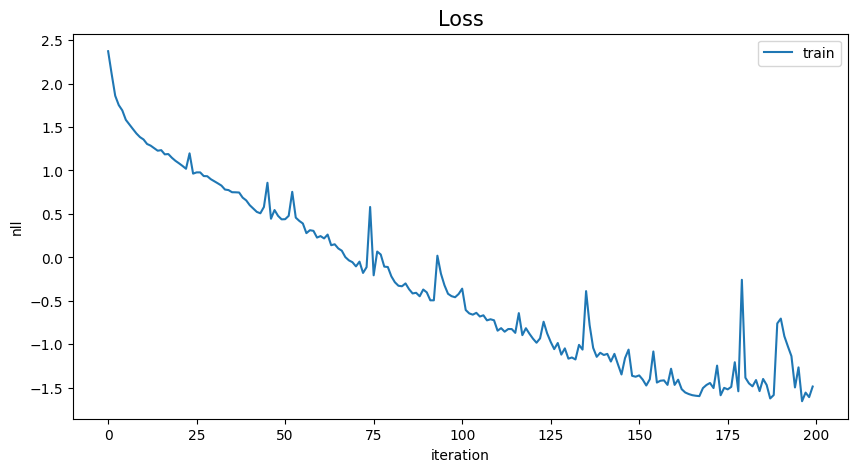

In [ ]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [ ]:
norm_model = model

### Inference

Just unitary tests

In [ ]:
batch = next(iter(test_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 203, 9]) torch.FloatTensor
past_values torch.Size([1, 203, 2]) torch.FloatTensor
past_observed_mask torch.Size([1, 203, 2]) torch.FloatTensor
future_time_features torch.Size([1, 100, 9]) torch.FloatTensor


In [ ]:
norm_batch = batch

In [ ]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

### Model save and Load

In [ ]:
model_path = '/content/drive/MyDrive/footbar/norm_model.pth'

In [ ]:
torch.save(norm_model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path,map_location=torch.device(device)))
norm_model = model.to(device)

# Action forecasting

## CNN + LSTM

### Dataset

#### Separate train and target

In [ ]:
feature_col = []
target_col = []

for col in actions_lag_df.columns:
  if ("-" in col):
    feature_col.append(col)
  if ("+" in col):
    target_col.append(col)

print(feature_col)
print(target_col)

['label_cross - 3', 'label_dribble - 3', 'label_pass - 3', 'label_rest - 3', 'label_run - 3', 'label_shot - 3', 'label_tackle - 3', 'label_walk - 3', 'label_cross - 2', 'label_dribble - 2', 'label_pass - 2', 'label_rest - 2', 'label_run - 2', 'label_shot - 2', 'label_tackle - 2', 'label_walk - 2', 'label_cross - 1', 'label_dribble - 1', 'label_pass - 1', 'label_rest - 1', 'label_run - 1', 'label_shot - 1', 'label_tackle - 1', 'label_walk - 1']
['label_cross + 0', 'label_dribble + 0', 'label_pass + 0', 'label_rest + 0', 'label_run + 0', 'label_shot + 0', 'label_tackle + 0', 'label_walk + 0']


In [ ]:
X = actions_lag_df.iloc[lag:len(actions_lag_df)-(forward - 1)][feature_col].values
y = actions_lag_df.iloc[lag:len(actions_lag_df)-(forward - 1)][target_col].values

In [ ]:
X.shape

(1184, 24)

In [ ]:
y.shape

(1184, 8)

In [ ]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([1184, 24])
torch.Size([1184, 8])


#### With sequence dimension

In [ ]:
X = torch.reshape(X,(X.shape[0],lag,int(X.shape[1]/lag)))

In [ ]:
print(X.shape)
X[0]

torch.Size([1184, 3, 8])


tensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
y = torch.reshape(y,(y.shape[0],forward,int(y.shape[1]/forward)))

In [ ]:
y = y.transpose(-2,-1)

In [ ]:
print(y.shape)
y[0]

torch.Size([1184, 8, 1])


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

#### Bias reduction

In [ ]:
props = torch.sum(y,0)
print(props.shape)
print(props)

torch.Size([8, 1])
tensor([[  4.],
        [ 78.],
        [ 32.],
        [ 35.],
        [552.],
        [ 18.],
        [ 31.],
        [434.]])


In [ ]:
torch.max(props)

tensor(552.)

In [ ]:
def outliers_idx(y):
  idx = []
  keep = []
  high_occ = []

  props = torch.sum(y,0)
  tot = props.transpose(0,1).squeeze().sum()
  mean = tot / props.shape[0]

  # FOR TESTING !!!
  mean = 79

  # Target over occurent indexes.
  for i in range(props.shape[0]):
    if props[i,0] > mean:
      idx.append(i)

      # Exclude them for low occurence maximum computation
      high_occ.append(props[i,0].item())
      props[i,0] = 0.


  low_max = torch.max(props).item()

  # High occurent label should appear in average as usual as
  #the most occurent label in low occurent label.
  mean_occ = low_max
  for i in range(len(idx)):
    keep_tensor = mean_occ / high_occ[i]
    keep.append(keep_tensor)


  return idx, keep

In [ ]:
outliers, keep = outliers_idx(y)

In [ ]:
print(outliers)
print(keep)

[4, 7]
[0.14130434782608695, 0.17972350230414746]


In [ ]:
def to_remove_bias(y, outliers, keep):
  cond = torch.ones(y.shape[0])
  # Do the process for each outliers indexes
  for idx in range(len(outliers)):
    out_idx = outliers[idx]
    keep_val = keep[idx] # Proportion to keep

    # For each row of the dataset, if the action is the outliers
    # keep the row with probability kee_val
    for row in range(y.shape[0]):
      curr_action = None
      for action_idx, action in enumerate(y[row]):
        if action[0] == 1.:
          curr_action = action_idx

      if curr_action == out_idx:
        rand = torch.rand(1).item()
        if rand > keep_val:
          cond[row] = 0

  return cond.int()

In [ ]:
cond = to_remove_bias(y, outliers, keep)

In [ ]:
X = X[cond != 0]
y = y[cond != 0]

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([361, 3, 8])
torch.Size([361, 8, 1])


In [ ]:
props = torch.sum(y,0)
print(props.shape)
print(props)

torch.Size([8, 1])
tensor([[ 4.],
        [78.],
        [32.],
        [35.],
        [83.],
        [18.],
        [31.],
        [80.]])


#### Dataloader

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, shuffle=False)

In [ ]:
batch_size=16

In [ ]:
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=False, batch_size=batch_size)

### Model

In [ ]:
class ConvLSTMNet(nn.Module):
    def __init__(self, input_dim, nb_feature, hidden_dim, num_layers, output_dim, forward_steps, drop_prob=0.):
        super(ConvLSTMNet, self).__init__()

        # Convolutional layers
        self.cnn = nn.Sequential(
        nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        )

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)

        # LSTM layers
        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Add dropout
        self.dropout = nn.Dropout(drop_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional LSTM doubles the hidden dimension

        self.forward_steps = forward_steps

    def forward(self, x):
        # Convolutional layers

        x = self.cnn(x)

        # LSTM layers
        lstm_out, _ = self.lstm(x)

        last_lstm = lstm_out[:, -self.forward_steps:, :]

        # Fully connected layer
        out = self.fc(last_lstm)  # We use the output of the last time steps according to forward steps

        out = nn.functional.softmax(out,dim=-1)

        out = out.transpose(-2,-1)

        return out

    def sample(self, x):
      output = self(x)

      sample = torch.zeros_like(output)

      for score_idx, score in enumerate(output):

        law = score.transpose(0,1).squeeze()
        dist = torch.distributions.categorical.Categorical(law)
        action = dist.sample().item()

        sample[score_idx,action,0] = 1.

      return sample


In [ ]:
hidden_dim = 100
input_dim = X_train.shape[-2]
nb_feature = X_train.shape[-1]
output_dim = y_train.shape[-2]# *  y_train.shape[-1]
num_layers = 2
drop_prob=0.1

model = ConvLSTMNet(input_dim=input_dim, nb_feature=nb_feature, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, forward_steps=forward, drop_prob=drop_prob)
model.to(device)

lr=0.001
nb_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch[0] = batch[0].to(device)
batch[1] = batch[1].to(device)

In [ ]:
print(batch[0].shape)
print(batch[1].shape)

torch.Size([16, 3, 8])
torch.Size([16, 8, 1])


In [ ]:
output = model(batch[0])

In [ ]:
output.shape

torch.Size([16, 8, 1])

In [ ]:
loss = criterion(output, batch[1])

In [ ]:
loss

tensor(2.0783, device='cuda:0', grad_fn=<DivBackward1>)

### Train

In [ ]:
device

device(type='cuda')

In [ ]:
# Train the model and log the progress to TensorBoard
writer = SummaryWriter()
history = []
model.train()

for epoch in range(nb_epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tepoch):

      if inputs.shape[0] != 16:
        continue
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      tepoch.set_postfix(loss=loss.item())
      if i % 100 == 99:
        torch.cuda.empty_cache()
        gc.collect()
        history.append(running_loss / 100)
        writer.add_scalar('training loss',
                          running_loss / 100,
                          epoch * len(train_loader) + i)
        running_loss = 0.0

writer.close()

100%|██████████| 16/16 [00:00<00:00, 147.21batch/s, loss=1.99]


In [ ]:
action_model = model

### Inference

#### Unit test

In [ ]:
model.eval()

In [ ]:
batch = next(iter(val_loader))

In [ ]:
action_batch = batch[0][0].unsqueeze(0)
print(action_batch.shape)

torch.Size([1, 3, 8])


In [ ]:
print(batch[0].shape)
print(batch[1].shape)

In [ ]:
batch[0] = batch[0].to(device)
batch[1] = batch[1].to(device)

In [ ]:
output = model(batch[0])

In [ ]:
print(output)

In [ ]:
sample = model.sample(batch[0])

In [ ]:
print(sample.shape)

In [ ]:
sample

In [ ]:
batch[1]

In [ ]:
loss = criterion(output, batch[1])

In [ ]:
loss

### Model save and Load

In [ ]:
model_path = '/content/drive/MyDrive/footbar/action_model.pth'

In [ ]:
torch.save(action_model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path,map_location=torch.device(device)))
action_model = model.to(device)

# Match simulation

## Process initial state

Example of possible file to take for inference.

In [ ]:
match_df = pd.read_json("/content/drive/MyDrive/footbar/match_1.json",
   convert_dates=True)

### Manage "no action" label

In [ ]:
occur = match_df.groupby(['label']).size()

In [ ]:
match_df.loc[match_df['label'] == 'no action']

,label,norm


In [ ]:
occur

label
cross        3
dribble     42
pass        24
rest        25
run        209
shot         6
tackle      20
walk       245
dtype: int64

Because **no action** label is very rare, **walk** label is very common and **no action** norm values are coherent with **walk** norm values, we choose to change **no action** label to **walk** label.

In [ ]:
match_df.replace('no action', 'walk', inplace=True)

In [ ]:
match_df.loc[match_df['label'] == 'no action']

,label,norm


### One hot action encoder

In [ ]:
def progress_array(action_length):
  return np.ndarray.tolist(np.linspace(0, 1, num=action_length))

In [ ]:
progress_column = match_df["norm"].apply(len).apply(progress_array)

In [ ]:
match_df.insert(len(match_df.columns), 'progress', progress_column.values)

In [ ]:
match_df

,label,norm,progress
0,walk,"[23.177037336396975, 23.361525285249378, 21.53...","[0.0, 0.014084507042253521, 0.0281690140845070..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...","[0.0, 0.018867924528301886, 0.0377358490566037..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...","[0.0, 0.014925373134328358, 0.0298507462686567..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...","[0.0, 0.013513513513513514, 0.0270270270270270..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...","[0.0, 0.005555555555555556, 0.0111111111111111..."
...,...,...,...
569,walk,"[21.245737438782683, 21.938836193196945, 21.24...","[0.0, 0.011904761904761904, 0.0238095238095238..."
570,walk,"[20.272347748199333, 21.820302584302983, 21.21...","[0.0, 0.02127659574468085, 0.0425531914893617,..."
571,run,"[90.21306005395827, 72.12712844635696, 63.5643...","[0.0, 0.03225806451612903, 0.06451612903225806..."
572,tackle,"[44.79510251441832, 27.26406867633046, 88.6164...","[0.0, 0.015873015873015872, 0.0317460317460317..."


In [ ]:
match_df = pd.get_dummies(match_df, columns=['label', ])

In [ ]:
match_df

,norm,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,"[23.177037336396975, 23.361525285249378, 21.53...","[0.0, 0.014084507042253521, 0.0281690140845070...",0,0,0,0,0,0,0,1
1,"[20.998214383911275, 19.182798059840767, 18.27...","[0.0, 0.018867924528301886, 0.0377358490566037...",0,0,0,0,0,0,0,1
2,"[21.95259682019565, 20.62720484424047, 22.5554...","[0.0, 0.014925373134328358, 0.0298507462686567...",0,0,0,0,0,0,0,1
3,"[19.39209748358647, 19.30460665293087, 18.9787...","[0.0, 0.013513513513513514, 0.0270270270270270...",0,0,0,0,0,0,0,1
4,"[22.069263037713093, 19.672270483203395, 19.88...","[0.0, 0.005555555555555556, 0.0111111111111111...",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
569,"[21.245737438782683, 21.938836193196945, 21.24...","[0.0, 0.011904761904761904, 0.0238095238095238...",0,0,0,0,0,0,0,1
570,"[20.272347748199333, 21.820302584302983, 21.21...","[0.0, 0.02127659574468085, 0.0425531914893617,...",0,0,0,0,0,0,0,1
571,"[90.21306005395827, 72.12712844635696, 63.5643...","[0.0, 0.03225806451612903, 0.06451612903225806...",0,0,0,0,1,0,0,0
572,"[44.79510251441832, 27.26406867633046, 88.6164...","[0.0, 0.015873015873015872, 0.0317460317460317...",0,0,0,0,0,0,1,0


### Action Data

#### Action history

In [ ]:
actions_col = []
for col in match_df.columns:
  if "label_" in col:
    actions_col.append(col)

In [ ]:
actions_col

['label_cross',
 'label_dribble',
 'label_pass',
 'label_rest',
 'label_run',
 'label_shot',
 'label_tackle',
 'label_walk']

In [ ]:
actions_df = match_df[actions_col]

In [ ]:
actions_df

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
569,0,0,0,0,0,0,0,1
570,0,0,0,0,0,0,0,1
571,0,0,0,0,1,0,0,0
572,0,0,0,0,0,0,1,0


### Norm Data

#### One row per norm

In [ ]:
continous_df = pd.DataFrame(columns=match_df.columns)

In [ ]:
for row_ind in match_df.index:
  duration = len(match_df["norm"][row_ind])
  for step in range(duration):
    new_row = dict()
    for column_name in match_df.columns:
      if "label_" in column_name:
        new_row[column_name] = match_df[column_name][row_ind]
      else:
        new_row[column_name] = match_df[column_name][row_ind][step]
    continous_df.loc[len(continous_df)] = new_row

In [ ]:
continous_df

,norm,progress,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk
0,23.177037,0.000000,0,0,0,0,0,0,0,1
1,23.361525,0.014085,0,0,0,0,0,0,0,1
2,21.535253,0.028169,0,0,0,0,0,0,0,1
3,23.400315,0.042254,0,0,0,0,0,0,0,1
4,23.007525,0.056338,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
27842,19.883602,0.885714,0,0,0,0,1,0,0,0
27843,11.203680,0.914286,0,0,0,0,1,0,0,0
27844,24.701711,0.942857,0,0,0,0,1,0,0,0
27845,30.045599,0.971429,0,0,0,0,1,0,0,0


In [ ]:
continous_df.to_csv('/content/drive/MyDrive/footbar/continous_df.csv', index=False)

### Place predicted features at the end of the dataframe.

In [ ]:
continous_df.columns

Index(['norm', 'progress', 'label_cross', 'label_dribble', 'label_pass',
       'label_rest', 'label_run', 'label_shot', 'label_tackle', 'label_walk'],
      dtype='object')

In [ ]:
nb_features = len(continous_df.columns)

In [ ]:
new_cols = ['label_cross', 'label_dribble', 'label_pass', 'label_rest', 'label_run', 'label_shot', 'label_tackle', 'label_walk','norm', 'progress']
continous_df=continous_df[new_cols]

In [ ]:
continous_df

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk,norm,progress
0,0,0,0,0,0,0,0,1,23.177037,0.000000
1,0,0,0,0,0,0,0,1,23.361525,0.014085
2,0,0,0,0,0,0,0,1,21.535253,0.028169
3,0,0,0,0,0,0,0,1,23.400315,0.042254
4,0,0,0,0,0,0,0,1,23.007525,0.056338
...,...,...,...,...,...,...,...,...,...,...
27842,0,0,0,0,1,0,0,0,19.883602,0.885714
27843,0,0,0,0,1,0,0,0,11.203680,0.914286
27844,0,0,0,0,1,0,0,0,24.701711,0.942857
27845,0,0,0,0,1,0,0,0,30.045599,0.971429


#### Scale data

In [ ]:
raw_values = continous_df[["norm","progress"]].values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(raw_values)

In [ ]:
continous_df_scaled = continous_df.copy()
continous_df_scaled["norm"] = scaled[:,0]
continous_df_scaled["progress"] = scaled[:,1]

In [ ]:
continous_df_scaled

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk,norm,progress
0,0,0,0,0,0,0,0,1,-0.944424,-1.000000
1,0,0,0,0,0,0,0,1,-0.943947,-0.971831
2,0,0,0,0,0,0,0,1,-0.948668,-0.943662
3,0,0,0,0,0,0,0,1,-0.943847,-0.915493
4,0,0,0,0,0,0,0,1,-0.944862,-0.887324
...,...,...,...,...,...,...,...,...,...,...
27842,0,0,0,0,1,0,0,0,-0.952937,0.771429
27843,0,0,0,0,1,0,0,0,-0.975371,0.828571
27844,0,0,0,0,1,0,0,0,-0.940483,0.885714
27845,0,0,0,0,1,0,0,0,-0.926672,0.942857


### Init batches

In [ ]:
if len(actions_df) >= 3:
  action_batch = torch.from_numpy(actions_df.iloc[-3:].values)
else:
  action_batch = torch.from_numpy(actions_df.values)
  while action_batch.shape[0] < 3:
    action_batch = torch.cat((action_batch[0].unsqueeze(0),action_batch),dim=0)

action_batch = action_batch[None,:].to(device).float()
print(action_batch.shape)

torch.Size([1, 3, 8])


In [ ]:
prediction_length = 100
lags_sequence =  [1, 2, 3]

In [ ]:
aged_df = continous_df_scaled.copy()

In [ ]:
aged_df['age'] = 1. + aged_df.index * 1e-4

In [ ]:
aged_df

,label_cross,label_dribble,label_pass,label_rest,label_run,label_shot,label_tackle,label_walk,norm,progress,age
0,0,0,0,0,0,0,0,1,-0.944424,-1.000000,1.0000
1,0,0,0,0,0,0,0,1,-0.943947,-0.971831,1.0001
2,0,0,0,0,0,0,0,1,-0.948668,-0.943662,1.0002
3,0,0,0,0,0,0,0,1,-0.943847,-0.915493,1.0003
4,0,0,0,0,0,0,0,1,-0.944862,-0.887324,1.0004
...,...,...,...,...,...,...,...,...,...,...,...
27842,0,0,0,0,1,0,0,0,-0.952937,0.771429,3.7842
27843,0,0,0,0,1,0,0,0,-0.975371,0.828571,3.7843
27844,0,0,0,0,1,0,0,0,-0.940483,0.885714,3.7844
27845,0,0,0,0,1,0,0,0,-0.926672,0.942857,3.7845


In [ ]:
actions_col = []
for col in match_df.columns:
  if "label_" in col:
    actions_col.append(col)
print(actions_col)

['label_cross', 'label_dribble', 'label_pass', 'label_rest', 'label_run', 'label_shot', 'label_tackle', 'label_walk']


In [ ]:
norm_batch = dict()
previous = prediction_length * 2 + len(lags_sequence)
if len(aged_df) >= previous:
  norm_batch['past_time_features'] = torch.from_numpy(aged_df.iloc[-previous:][['age'] + actions_col].values).to(device).float().unsqueeze(0)
  norm_batch['past_values'] = torch.from_numpy(aged_df.iloc[-previous:][['norm','progress']].values).to(device).float().unsqueeze(0)
else:
  init_len = len(aged_df)
  norm_batch['past_time_features'] = torch.zeros((1,previous,9)).float().to(device)
  norm_batch['past_time_features'][0,previous - init_len:] = torch.from_numpy(aged_df[['age'] + actions_col].values).to(device).float()

  norm_batch['past_values'] = torch.zeros((1,previous,2)).float().to(device)
  norm_batch['past_values'][0,previous - init_len:] = torch.from_numpy(aged_df.iloc[-previous:][['norm','progress']].values).to(device).float()

norm_batch['past_observed_mask'] = torch.ones((1,previous,2)).float().to(device)
norm_batch['future_time_features'] = torch.zeros((1,prediction_length,9)).float().to(device)

In [ ]:
for k, v in norm_batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 203, 9]) torch.cuda.FloatTensor
past_values torch.Size([1, 203, 2]) torch.cuda.FloatTensor
past_observed_mask torch.Size([1, 203, 2]) torch.cuda.FloatTensor
future_time_features torch.Size([1, 100, 9]) torch.cuda.FloatTensor


In [ ]:
prediction_length

100

In [ ]:
prediction_length * 2 + len(lags_sequence)

203

In [ ]:
norm_batch.keys()

dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features'])

## Simulation loop

In [ ]:
init_state = [action_batch, norm_batch]

In [ ]:
def simulation(action_model, norm_model, duration, init_state):
  norm_model.eval()
  action_model.eval()

  # Convert duration in minutes into max step at 50Hz
  max_steps = int(duration * 60 * 50)
  step = 0

  action_batch, norm_batch = init_state[0], init_state[1]
  action_batch = action_batch.to(device)

  nb_future = norm_batch["future_time_features"].shape[1]
  nb_max_future = norm_batch["future_time_features"].shape[1]
  nb_past = norm_batch["past_values"].shape[1]

  forecasts_ = []
  forecasts = torch.zeros((1,2))
  labels = np.zeros((1,8))

  while step < max_steps:

    # Forecast action
    next_action = action_model.sample(action_batch)

    next_action_vec = next_action.transpose(1,2)
    labels = np.concatenate((labels,next_action_vec.squeeze(0).cpu().numpy()), axis=0)

    action_batch = torch.cat([action_batch[0,1:,:].unsqueeze(0),next_action_vec],dim=1)

    future_action = next_action.squeeze(0).transpose(0,1)
    action_feature = torch.cat(nb_max_future * [future_action],dim=0)
    norm_batch["future_time_features"][0,:,1:9] = action_feature

    # Forecast norms
    outputs = norm_model.generate(
        past_time_features=norm_batch["past_time_features"].to(device),
        past_values=norm_batch["past_values"].to(device),
        future_time_features=norm_batch["future_time_features"].to(device),
        past_observed_mask=norm_batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

    #print("torch.from_numpy(forecasts_[-1][0,0,:,-1])")
    #print(torch.from_numpy(forecasts_[-1][0,0,:,-1]))

    for prog_idx, prog in enumerate(forecasts_[-1][0,0,:,-1]):
      if prog > 0.85:
        break
    nb_future = prog_idx+1
    forecasts_[-1] = forecasts_[-1][:,:,:nb_future,:]
    forecasts_[-1][0,0,:,-1] = np.linspace(start=-1.,stop=1.,num=nb_future)
    forecasts_[-1][0,0,-1,-1] = -1

    save_past_time = torch.clone(norm_batch["past_time_features"][0,nb_future:,:])
    norm_batch["past_time_features"][0,:nb_past - nb_future,:] = save_past_time
    norm_batch["past_time_features"][0,nb_past - nb_future:,:] = norm_batch["future_time_features"][0,:nb_future]

    save_past_values = torch.clone(norm_batch["past_values"][0,nb_future:,:])
    norm_batch["past_values"][0,:nb_past - nb_future,:] = save_past_values


    norm_batch["past_values"][0,nb_past - nb_future:,:] = torch.from_numpy(forecasts_[-1][0,0,:,:])

    save_future_time = norm_batch["future_time_features"][0,nb_future:,0]
    norm_batch["future_time_features"][0,:nb_max_future-nb_future,0] = save_future_time
    for i in range(nb_max_future-nb_future,nb_max_future):
      norm_batch["future_time_features"][0,i,0] = norm_batch["future_time_features"][0,i-1,0] + 1e-4

    forecasts = np.concatenate((forecasts,forecasts_[-1][0,0]),axis=0)

    step += nb_future
    print(f"Gait steps: {nb_future}")
    print(f"Total steps: {step}")

  mean = np.mean(forecasts,axis=0)

  for val in forecasts:
    if val[-2] < -1.:
      val[-2] = mean[-2]

  forecasts[0,-1] = -1

  return forecasts, labels[1:]


action_model and norm_model are defined in the **Train** section or the **Model save and Load** section for each model.

In [ ]:
forecasts, labels = simulation(action_model=action_model, norm_model=norm_model, duration=0.5, init_state=init_state)

Gait steps: 90
Total steps: 90
Gait steps: 100
Total steps: 190
Gait steps: 71
Total steps: 261
Gait steps: 100
Total steps: 361
Gait steps: 99
Total steps: 460
Gait steps: 100
Total steps: 560
Gait steps: 98
Total steps: 658
Gait steps: 100
Total steps: 758
Gait steps: 81
Total steps: 839
Gait steps: 95
Total steps: 934
Gait steps: 86
Total steps: 1020
Gait steps: 97
Total steps: 1117
Gait steps: 100
Total steps: 1217
Gait steps: 82
Total steps: 1299
Gait steps: 86
Total steps: 1385
Gait steps: 93
Total steps: 1478
Gait steps: 100
Total steps: 1578


In [ ]:
val_unscaled = scaler.inverse_transform(forecasts)

In [ ]:
val_unscaled.shape

(1579, 2)

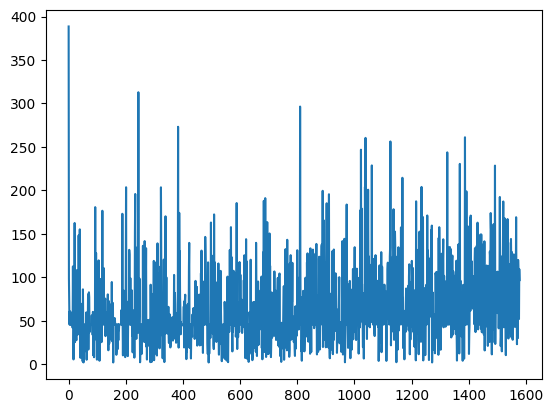

In [ ]:
plt.plot(val_unscaled[:,-2])
plt.show()

## Postprocessing

In [ ]:
labels_list = []
for col in match_df.columns:
  if "label_" in col:
    labels_list.append(col)

print(labels_list)

In [ ]:
forecasts[:200,-1]

In [ ]:
match_out = []
label_idx = 0
val_unscaled = scaler.inverse_transform(forecasts)

gait = None
prev_prog = 0.

for pred_idx, pred in enumerate(forecasts):
  if (pred[-1] <= -1.) and (prev_prog <= -1.):
    if gait != None:
      match_out.append(gait)
    gait = dict()
    #print("new")

    label_vec = labels[label_idx]
    #print(label_vec)
    for ind_idx, ind in enumerate(label_vec):
      if ind != 0.:
        gait["label"] = labels_list[ind_idx].split('_')[-1]

    #print(gait["label"])
    label_idx += 1

    gait["norm"] = [val_unscaled[pred_idx][-2]]


  elif gait != None:
    gait["norm"].append(val_unscaled[pred_idx][-2])

  prev_prog = pred[-1]


In [ ]:
match_out

## Save file

In [ ]:
match_json = json.dumps(str(match_out))

In [ ]:
with open("/content/drive/MyDrive/footbar/match_json.json", "w") as outfile:
    outfile.write(match_json)